In [1]:
import tensorflow as tf
#from tensorflow_examples.models.pix2pix import pix2pix
import PIL
from PIL import Image
import numpy as np
import os
#import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
width = 960
height = 960
channels = 3

In [3]:
def make_dataset():
#creates an array for the input (image) and output (mask) data

    #define paths 
    image_path = "datasets/L8 SPARCS/photos/"
    mask_path =  "datasets/L8 SPARCS/mask/"

    #file names 
    image_products = sorted(os.listdir(image_path))
    mask_products = sorted(os.listdir(mask_path))

    #allocate
    x = np.zeros((80,width, height, 3), dtype=np.uint16)
    y = np.zeros((80,width, height), dtype=np.uint16)
    
    n = len(image_products)
    
    for i in range(1,n):
        
        #load images into an array
        image_name = image_products[i]
        im = Image.open(image_path + image_name).resize((width,height))
        x[i-1,:, :, 0:3] = np.asarray(im)
        
        
        #load masks into an array
        mask_name = mask_products[i-1]
        ma = Image.open(mask_path + mask_name).resize((width,height))
        y[i-1,:, :] = np.asarray(ma)
        
        
    return x,y
    

In [4]:
def patch_array(input_array, n_segments_x, n_segments_y):
    
    n_pics, width, height = np.shape(input_array)
    #pixel measurements of new patches
    length_x = int(width/n_segments_y) 
    length_y = int(height/n_segments_x)
    #allocate array
    a = np.zeros((n_pics* 
                  n_segments_x*n_segments_y, length_x, length_y), dtype=np.uint16)
    
    for n in range(n_pics):
        for h in range(n_segments_y):
            for w in range(n_segments_x):
                i = 9*n + 3*h + w #3=n_segments?
                a[i] = input_array[n,h*length_y:(h+1)*length_y, w*length_x:(w+1)*length_x] 

    return a

In [5]:
def patch_array_3(input_array, n_segments_x, n_segments_y):
    #patches image with three channels #merge functions??
    
    n_pics, width, height, channels = np.shape(input_array)
    #pixel measurements of new patches
    length_x = int(width/n_segments_y) 
    length_y = int(height/n_segments_x)
    
    #allocate array
    a = np.zeros((n_pics*n_segments_x*n_segments_y, length_x, length_y,channels), dtype=np.uint16)
    
    for n in range(n_pics):
        for h in range(n_segments_y):
            for w in range(n_segments_x):
                i = 9*n + 3*h + w
                a[i] = input_array[n,h*length_y:(h+1)*length_y, w*length_x:(w+1)*length_x,:] 

    return a

In [6]:
def make_dataset_patched(n_segments_x, n_segments_y):
#creates an array for the input (image) and output (mask) data and patches it into smaller segments
#don't use width height again!
    #define paths 
    image_path = "datasets/L8 SPARCS/photos/"
    mask_path =  "datasets/L8 SPARCS/mask/"

    #file names 
    image_products = sorted(os.listdir(image_path))
    mask_products = sorted(os.listdir(mask_path))

    #allocate
    x = np.zeros((80,width, height, 3), dtype=np.uint16)
    y = np.zeros((80,width, height), dtype=np.uint16)
    
    n = len(image_products)
    
    for i in range(1,n):
        
        #load images into an array
        image_name = image_products[i]
        im = Image.open(image_path + image_name).resize((width,height))
        x[i-1,:, :, 0:3] = np.asarray(im)
        
        
        #load masks into an array
        mask_name = mask_products[i-1]
        ma = Image.open(mask_path + mask_name).resize((width,height))
        y[i-1,:, :] = np.asarray(ma)
    
    #patch   
    x = patch_array_3(x,n_segments_x, n_segments_y)
    y = patch_array(y,n_segments_x, n_segments_y)
    
    return x,y
    

In [20]:
def reduce_classification(mask_array): 
    n_pictures, mask_width, mask_height = np.shape(mask_array)
    
    for n in range(n_pictures):
        for h in range(mask_height):
            for w in range(mask_width):
                if mask_array[n,h,w] == 1:
                    mask_array[n,h,w] = 0
                elif mask_array[n,h,w] == 2 or mask_array[n,h,w] == 3 or mask_array[n,h,w] == 4 or mask_array[n,h,w] == 6:
                    mask_array[n,h,w] = 1
                elif mask_array[n,h,w] == 5:
                    mask_array[n,h,w] = 2
    
    return mask_array

In [21]:
x, y = make_dataset_patched(3,3)

In [22]:
y = reduce_classification(y)

In [23]:
#use the stored y instead to reduce processing and skip the previous step
ysimple = y
%store ysimple

Stored 'ysimple' (ndarray)


In [24]:
n_classes = np.max(y) + 1

In [25]:
#turn classifications into binaries
y_train_cat = tf.keras.utils.to_categorical(y, num_classes = n_classes)


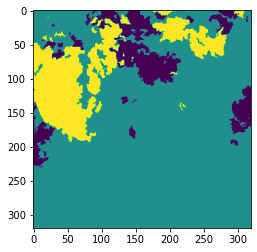

In [32]:
plt.imshow(y[250])

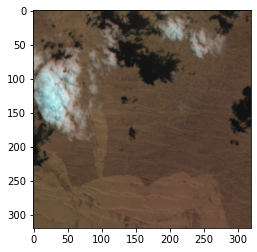

In [33]:
plt.imshow(x[250])

In [34]:
def U_net_model(IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS, N_CLASSES):
    # width and height need to be dividable by 32!!!
    #build model
    inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
    s = inputs #wat???

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(N_CLASSES, (1, 1), activation='softmax')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #model.summary()
    
    return model

In [35]:
model = U_net_model(320, 320, channels, n_classes)

In [28]:
x_test = x[100:120]
y_test_cat = y_train_cat[100:120]

In [37]:
history = model.fit(x[0:640], y_train_cat[0:640], 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=30,
                    validation_data=(x[640:], y_train_cat[640:]),
                    #class_weight=class_weights,
                    shuffle=False)

Epoch 1/30
40/40 [==============================] - 194s 5s/step - loss: 2.3346 - accuracy: 0.6408 - val_loss: 0.5346 - val_accuracy: 0.7544
Epoch 2/30
40/40 [==============================] - 187s 5s/step - loss: 0.5652 - accuracy: 0.6981 - val_loss: 0.4905 - val_accuracy: 0.7366
Epoch 3/30
40/40 [==============================] - 187s 5s/step - loss: 0.4766 - accuracy: 0.7185 - val_loss: 0.4558 - val_accuracy: 0.7597
Epoch 4/30
40/40 [==============================] - 187s 5s/step - loss: 0.4301 - accuracy: 0.7337 - val_loss: 0.4389 - val_accuracy: 0.7742
Epoch 5/30
40/40 [==============================] - 185s 5s/step - loss: 0.4146 - accuracy: 0.7491 - val_loss: 0.4283 - val_accuracy: 0.7850
Epoch 6/30
40/40 [==============================] - 190s 5s/step - loss: 0.4009 - accuracy: 0.7604 - val_loss: 0.4098 - val_accuracy: 0.7861
Epoch 7/30
40/40 [==============================] - 188s 5s/step - loss: 0.3885 - accuracy: 0.7738 - val_loss: 0.3967 - val_accuracy: 0.7914
Epoch 8/30
40

KeyboardInterrupt: 

In [38]:
prediction = model.predict(x[650:660])

In [39]:
prediction = np.argmax(prediction, axis=-1)

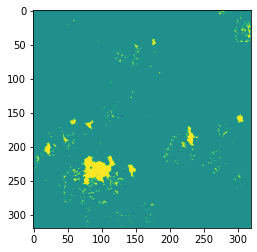

In [51]:
plt.imshow(prediction[9])

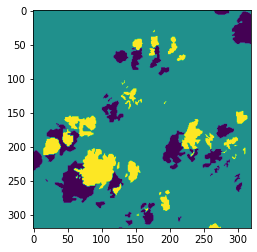

In [52]:
plt.imshow(y[659])

In [1]:
model.save('cloud1.hdf5')

NameError: name 'model' is not defined